# Project idea : 
**Help young adults to take care of administrative documents necessary for them**
1. set the requirements
2. explore the tools necessary for the project & put them in a utils file
3. set a .env with API keys


In [1]:
# %pip install r- ./requirements.txt 

In [17]:
pip install streamlit

  Using cached streamlit-1.51.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-6.2.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached numpy-2.3.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached protobuf-6.33.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached pyarrow-21.0.0-cp313-cp313-win_amd64.whl.metadata (3.4 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl

In [18]:
import streamlit

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
if os.path.exists(".env"):
    load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [4]:
# define our client 
llm_client = ChatOpenAI (model_name = "gpt-5", temperature= 0.0)

In [5]:
import re
import io
import requests
from langchain_core.tools import tool
from typing import Annotated, Sequence, TypedDict, Optional
from typing import Annotated, Optional
import shutil
from pathlib import Path
import json
import PyPDF2

In [6]:
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict): #1 define state 
    messages: Annotated[Sequence[BaseMessage], add_messages]
    system_prompt: SystemMessage

In [7]:
# Create a path where the doc will be loaded from 
UPLOAD_DIRECTORY = Path("./Project_Agentic/") / "uploads"
UPLOAD_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [8]:
# Convert .pdf to .txt
def pdf_to_text(pdf_path: str) -> str:
    text = ""
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# define tools
@tool
def upload_document(source_path: str, destination_name: str = None) -> str:
    """
    upload the document 
    """
    destination_name = destination_name or Path(source_path).name
    destination_path = UPLOAD_DIRECTORY / destination_name
    shutil.copy(source_path, destination_path)
    return f"File uploaded successfully as {destination_name}"

@tool
def read_document(file_name: str, start: int = None, end: int = None) -> str:
    """
    Read the document 
    """
    with (UPLOAD_DIRECTORY / file_name).open("r", encoding="utf-8") as f:
        lines = f.readlines()
    start = start or 0
    return "\n".join(lines[start:end])

@tool
def answer_from_document(user_message: str, file_name: str) -> str:
    """
    generate an answer with information given from the document 
    """
    
    document_content = read_document.invoke({"file_name": file_name})
    messages = [
        {"role": "system", "content": "You answer questions based only on the provided document."},
        {"role": "user", "content": f"Document content:\n{document_content}"},
        {"role": "user", "content": f"Question: {user_message}"}
    ]
    response = llm_client.invoke(messages)
    return response.content

def list_steps_dynamic(process_name: str) -> str:
    """
    Uses the LLM to generate step-by-step instructions
    for any user input process or task.
    """
    prompt = f"Provide clear, step-by-step instructions to complete the following process:\n'{process_name}'"
    
    # Call the LLM
    messages = [
        {"role": "system", "content": "You provide clear, practical, step-by-step instructions."},
        {"role": "user", "content": prompt}
    ]
    response = llm_client.invoke(messages)
    return response.content

@tool
def list_steps(process_name: str) -> str:
    """
    list all of the steps needed
    """
    return list_steps_dynamic(process_name)


In [9]:
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    # Use getattr with default empty list
    if not getattr(last_message, "tool_calls", []):
        return "end"
    return "continue"



In [10]:
# bind the tools 
tools_doc = [read_document, upload_document, answer_from_document]
llm_with_tools_doc = llm_client.bind_tools(tools_doc)

tools_doc_by_name = {tool_doc.name: tool_doc for tool_doc in tools_doc}
tools_doc_by_name

{'read_document': StructuredTool(name='read_document', description='Read the document', args_schema=<class 'langchain_core.utils.pydantic.read_document'>, func=<function read_document at 0x000001C22AD8ECA0>),
 'upload_document': StructuredTool(name='upload_document', description='upload the document', args_schema=<class 'langchain_core.utils.pydantic.upload_document'>, func=<function upload_document at 0x000001C22AD8EB60>),
 'answer_from_document': StructuredTool(name='answer_from_document', description='generate an answer with information given from the document', args_schema=<class 'langchain_core.utils.pydantic.answer_from_document'>, func=<function answer_from_document at 0x000001C22AD8ED40>)}

In [11]:
tools_template = [list_steps]
llm_with_tools_template = llm_client.bind_tools(tools_template)

tools_temp_by_name = {tool_template.name: tool_template for tool_template in tools_template}
tools_temp_by_name

{'list_steps': StructuredTool(name='list_steps', description='list all of the steps needed', args_schema=<class 'langchain_core.utils.pydantic.list_steps'>, func=<function list_steps at 0x000001C22AD8F2E0>)}

In [12]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

# tool node
def tools_doc_node(state: AgentState) -> AgentState:
    outputs = []
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # handle both dict-style and attribute-style tool calls
        tool_args = (
            tool_call.get("args", {}) 
            if isinstance(tool_call, dict) 
            else tool_call.args
        )

        tool_result = tools_doc_by_name[tool_call["name"]](tool_args)

        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outputs}

def tools_temp_node(state: AgentState) -> AgentState:
    outputs = []
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # handle both dict-style and attribute-style tool calls
        tool_args = (
            tool_call.get("args", {}) 
            if isinstance(tool_call, dict) 
            else tool_call.args
        )

        tool_result = tools_temp_by_name[tool_call["name"]](tool_args)

        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outputs}


# node that calls the llm model // State evolves while going from a node to another 
def call_llm_node(state: AgentState,
                  config: RunnableConfig) -> AgentState:

    response = llm_with_tools_doc.invoke(
    {"messages": [state["system_prompt"]] + state["messages"]},
    config=config) #node makes call to llm
    # We return a list, because this will get added to the exisitng list of messages
    return {"messages": [response]}



# if loop : condition edge that determines whether to continue or not
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else: 
        return "continue"

In [13]:
from langgraph.graph import StateGraph, START, END

# Graph
workflow = StateGraph(AgentState) 

# Define the two nodes we will cycle between
workflow.add_node("llm", call_llm_node)  #llm
workflow.add_node("tool doc", tools_doc_node)   #tool
workflow.add_node("tool template", tools_temp_node)  

workflow.add_edge(START, "llm")
workflow.add_edge("llm", "tool doc")

# loop
workflow.add_conditional_edges(  
    "tool doc", 
    
    should_continue,
    {
        # If `tools`, then call the tool node.
        "continue": "tool template", 
        },
    )
# Finally, we need to add an edge from tool back to agent
workflow.add_edge("tool template", "tool doc")


workflow.add_edge("tool template", END)

graph = workflow.compile()

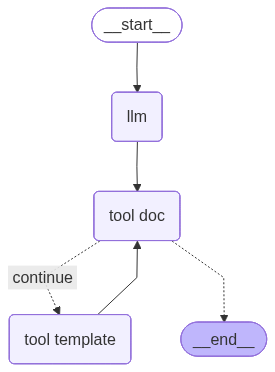

In [14]:
display(graph)

In [15]:
# --- Step 1: Upload PDF ---
local_pdf_path = "./test.pdf"
upload_document.invoke({"source_path": local_pdf_path, "destination_name": "test.pdf"})

'File uploaded successfully as test.pdf'

In [16]:
# --- Step 2: Convert PDF to text ---
text_content = pdf_to_text(local_pdf_path)
txt_file_name = "test.txt"
with open(UPLOAD_DIRECTORY / txt_file_name, "w", encoding="utf-8") as f:
    f.write(text_content)
